In [29]:
# Imports
import antares_devkit as dk
from antares_devkit.models import DevKitLocus

In [2]:
# Define a Paczyński microlensing model
def paczynski(t, t0, u0, tE, F_s):
    """
    Paczyński microlensing light curve model
    t0 : peak time
    u0 : impact parameter
    tE : Einstein crossing time
    F_s : source flux
    F_b : blended flux
    """
    u = np.sqrt(u0**2 + ((t - t0) / tE) ** 2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return F_s * (A) + (1-F_s)
    
def fit_paczynski(times, mags, flxs, flx_errs):
    """
    Fit the Paczyński microlensing model to flux data.
    Returns best-fit parameters and chi-squared value.
    """
    if len(times) < 4:
        return None, None  # Not enough data

    # initial guesses
    t0_guess = times[np.argmin(flxs)]
    u0_guess = 1.0 / (np.max(flxs))

    tE_guess = 20.0
    F0_guess = 0.5


    initial_guess = [t0_guess, u0_guess, tE_guess, F0_guess]

    bounds = (
                        [times.min() - 50, 0, 1.0, 0.0],
                        [times.max() + 50, np.inf, 500.0, 1]
                    )


    try:
        popt, _ = curve_fit(
            paczynski,
            times, flxs,
            p0=initial_guess,
            sigma=flx_errs,
            bounds=bounds,

            maxfev=5000
        )
        chi2 = np.sum(((flxs - paczynski(times, *popt)) / flx_errs) ** 2) / len(times)
        return popt, chi2
    except Exception as e:
        print(f"  Paczynski fitting error: {e}")
        return None, None

def mag_to_flux(mag, F0=1.0):
    """
    Convert magnitude to flux.
    
    Parameters:
    - mag : magnitude (float or array)
    - F0 : reference flux (zeropoint), default=1.0 for relative flux
    
    Returns:
    - flux : flux corresponding to the magnitude
    """
    flux = F0 * 10**(-0.4 * mag)
    flux = flux/np.min(flux)
    return flux
    
def magerr_to_fluxerr(mag, mag_err, F0=1.0):
    """
    Convert magnitude uncertainty to flux uncertainty.
    
    Parameters:
    - mag : magnitude value or array
    - mag_err : magnitude uncertainty value or array
    - F0 : zeropoint flux (default=1.0 for relative flux)
    
    Returns:
    - flux_err : flux uncertainty
    """
    flux = mag_to_flux(mag, F0)
    flux_err = 0.4 * np.log(10) * flux * mag_err
    return flux_err

In [3]:
# Chi squared functions for BAGLE model
def calc_chi2_mean(data, n_phot_sets = 1, verbose=False):
        """
        Parameters
        ----------
        params : str or dict, optional
            model_params = 'best' will load up the best solution and calculate
            the chi^2 based on those values. Alternatively, pass in a dictionary
            with the model parameters to use.
        """
        # Get likelihoods.
        lnL_phot = log_likely_photometry(data)

        # Lists to store lnL, chi2, and constants for each filter.
        chi2_phot_filts = []
        lnL_const_phot_filts = []
    
        for nn in range(n_phot_sets):
            mag_err = data['mag_err' + str(nn + 1)]
            
            # Calculate the lnL for just a single filter.
            lnL_phot_nn = log_likely_photometry(data, nn)

            # Calculate the chi2 and constants for just a single filter.
            lnL_const_phot_nn = -0.5 * np.log(2.0 * math.pi * mag_err**2)
            lnL_const_phot_nn = lnL_const_phot_nn.sum()
            
            chi2_phot_nn = (lnL_phot_nn - lnL_const_phot_nn) / -0.5

            # Save to our lists
            chi2_phot_filts.append(chi2_phot_nn)
            lnL_const_phot_filts.append(lnL_const_phot_nn)

        lnL_const_phot = sum(lnL_const_phot_filts)


        # Calculate chi2.
        chi2 = (lnL_phot - lnL_const_phot) / -0.5

        if verbose:
            fmt = '{0:13s} = {1:f} '
            for ff in range(n_phot_sets):
                print(fmt.format('chi2_phot' + str(ff + 1), chi2_phot_filts[ff]))
                
            print(fmt.format('chi2', chi2))

        return chi2

def log_likely_photometry(data, n_phot_sets = 1, verbose = False):

    lnL_phot = 0.0

    for i in range(n_phot_sets):
        t_phot = data['t_phot' + str(i + 1)]
        mag = data['mag' + str(i + 1)]
        mag_err = data['mag_err' + str(i + 1)]

        # commenting out weight stuff for now
        #weight = self.weights[i]
        lnL_phot_unwgt = log_likely_photometry_each(t_phot, mag, mag_err, i)
        lnL_phot_i = lnL_phot_unwgt #* weight
        lnL_phot += lnL_phot_i

        if verbose:
            print(f'lnL_phot: i = {i} L_unwgt = {lnL_phot_unwgt:15.1f}, L_wgt = {lnL_phot_i:15.1f}, weight = {weight:.1e}')


    return lnL_phot

def log_likely_photometry_each(t_obs, mag_obs, mag_err_obs, filt_idx=0):
    """
    Get the natural log of the likelihood for the input photometric data in the 
    specified filter or data sets. Note, this function returns a list and it 
    is the full ln(likelihood), including the normalization constant. 

    Parameters
    ----------
    t_obs : array_like
        List of times in MJD for the observations. 
    mag_obs : array_like
        List of observed photometric measurements of the microlensing event in magnitudes. 
        Length must be the same as t_obs.
    mag_obs_err : array_like
        List of observed photometric uncertainties of the microlensing event in magnitudes. 
        Length must be the same as t_obs.
    filt_idx : int, optional
        Index of the photometric filter or data set.

    Returns
    -------
    ln_L : array_like
        List of ln(likelihood) for each photometric measurement. 

    """

    chi2_m = get_chi2_photometry_mean(t_obs, mag_obs, mag_err_obs, filt_idx=filt_idx)

    lnL_const_m = get_lnL_constant(mag_err_obs)

    lnL = (-0.5 * chi2_m) + lnL_const_m

    return lnL.sum()

# Writing a preliminary microlensing filter that reads in the photometry

In [4]:
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
from astropy.table import MaskedColumn
import warnings
import astropy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import skew
from antares_devkit.models import BaseFilter
from antares_client import search
from bagle import model, model_fitter
from astropy.stats import sigma_clip
from scipy.stats import chi2
import math

In [63]:
#from antares_microlensing_filter import microlensing

class microlensing(BaseFilter):    
    INPUT_LOCUS_PROPERTIES = [
        'ztf_object_id',
    ]

    REQUIRED_TAGS = ['lc_feature_extractor']

    OUTPUT_TAGS = [
        {
            'name': 'microlensing_candidate',
            'description': 'Locus - a transient candidate - exhibits a microlensing-like variability',
        }
    ]


    def make_lc(self, locus):

        with warnings.catch_warnings():
            # The cast of locus.timeseries: astropy.table.Table to a pandas
            # dataframe results in the conversion of some integer-valued
            # columns to floating point represntation. This can result in a
            # number of noisy warning so we will catch & ignore them for the
            # next couple of lines.
            warnings.simplefilter("ignore", astropy.table.TableReplaceWarning)
            df = locus.timeseries().to_pandas()

        data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
        
        dn = data.dropna()
        times=dn['ant_mjd'][dn['ztf_fid']==1]
        mags = dn['ztf_magpsf'][dn['ztf_fid']==1]
        mags_err = dn['ztf_sigmapsf'][dn['ztf_fid']==1]
        flxs = mag_to_flux(mags)
        flx_errs = magerr_to_fluxerr(mags, mags_err)
        

    def is_known_other_phenomenon(self, locus, locus_params):
        """
        Method to check the locus' pre-existing parameters indicated that it has
        been identified or is likely to be a variable of a type other than microlensing

        :param locus:
        :param locus_params:
        :return: boolean
        """

        # Default result is not a known variable
        known_var = False
        
        # Tunable detection thresholds.
        # Ref: Sokolovsky et al. 2016: https://ui.adsabs.harvard.edu/abs/2017MNRAS.464..274S/abstract
        period_peak_sn_threshold = 20.0  # Based on tests with ZTF alerts
        stetson_k_threshold = 0.8  # The expected K-value for a constant lightcurve with Gaussian noise

        # Check for periodicity
        if locus_params['feature_period_s_to_n_0_magn_r'] >= period_peak_sn_threshold:
            known_var = True

        # Check Stetson-K index
        if locus_params['feature_stetson_k_magn_r'] <= stetson_k_threshold:
            known_var = True

        # Check whether this event is associated with a GW event
        # TODO port to new value
        #if 'plausible_gw_events_assoc' in locus.alert.properties.keys():
        #    known_var = True

        # If the alert has parameters from JPL Horizons, then it is likely cause by
        # a Solar System object
        if 'horizons_targetname' in locus_params.keys():
            known_var = True

        # Check whether the ANTARES crossmatch against known galaxy catalogs threw up any matches
        # The locus.catalog_objects attribute is a dictionary of lists of known objects for each 
        # catalogs.  If a match has been found, then the key for the corresponding catalog will be 
        # in the list of keys.  So we can use that to check for matches with galaxy catalogs. 
        # Of those available in the list the Gemini NIR survey of known quasars is the closest
        if 'gnirs_dqs' in locus.catalog_objects.keys():
            known_var = True
            
        return known_var

    def calculate_eta(self, mag):
        """ Via puzle https://github.com/jluastro/puzle/blob/main/puzle/stats.py"""
        delta = np.sum((np.diff(mag)*np.diff(mag)) / (len(mag)-1))
        variance = np.var(mag)
        eta = delta / variance
        return eta

    def return_eta_residual_slope_offset(self):
        """ 
        Via puzle https://github.com/jluastro/puzle/blob/main/puzle/cands.py
        TODO is 6 months and a year - calculate slope and intercept based on real Rubin data
        """
        slope = 3.8187919463087248
        offset = -0.07718120805369133
        return slope, offset

    def make_bagle_data_dir(self, times, mags, errors):
        data = {}
        data['target'] = 'single_event'
        data['phot_data'] = 'alert'
        data['phot_files'] = ['locus']
        data['ast_data'] = 'None'
        data['ast_files'] = []
        
        data['t_phot1'] = times
        data['mag1'] = mags
        data['mag_err1'] = errors

        return data

    def is_microlensing_candidate(self, locus, times, mags, errors, verbose):
        """
        Example of a set of Microlensing detection criteria
        """
        if len(times) < 10:  # Too few data points
            if verbose == True:
                print('Too Few Datapoints')
            return False

        # Extract the full parameter set from the locus and the alert
        locus_params = locus.properties

        # Use the pre-calculated properties of the locus to eliminate those
        # which show signs of variability, e.g. in their periodicity signature or
        # the Stetson-K index
        known_var = self.is_known_other_phenomenon(locus, locus_params)
        if known_var:
            if verbose == True:
                print('Other known phenomenon')
            return False

        # Sort data by time
        sorted_idx = np.argsort(times)
        times, mags, errors = times[sorted_idx], mags[sorted_idx], errors[sorted_idx]
        npts = len(times)

        # 1. Check for smoothness (low skewness means symmetric light curve)
        # TODO: Check for threshold with parallax and maybe remove or lower threshold
        if abs(skew(mags)) > 1:
            if verbose == True:
                print('Too skewed')
            return False

        # TODO is 6 months and a year - calculate this based on percentile of real data
        eta_thresh = 1.255 # Avg from ZTF level 2 (low eta)
        # Do check for existance since if there's only one band of data, only one will exist
        eta_r_exists = 'feature_eta_e_magn_r' in locus_params.keys()
        eta_g_exists = 'feature_eta_e_magn_g' in locus_params.keys()
        eta_r = locus_params['feature_eta_e_magn_r']
        eta_g = locus_params['feature_eta_e_magn_g']
        if eta_r_exists and eta_g_exists:
            if eta_r >= eta_thresh and eta_g >= eta_thresh:
                if verbose == True:
                    print('Failed von Neumann threshold')
                return False
        elif eta_r_exists:
            if eta_r >= eta_thresh:
                if verbose == True:
                    print('Failed von Neumann threshold')
                return False
        elif eta_g_exists:
            if eta_g >= eta_thresh:
                if verbose == True:
                    print('Failed von Neumann threshold')
                return False

        # 2. Check variability (microlensing should have a clear peak)
        # Decrease threshold with longer baseline
        # Q for broker - 365 days or full lightcurve?
        if np.ptp(mags) < 0.5:  # Peak-to-peak magnitude difference
            if verbose == True:
                print('Too small magnitude change')
            return False

        flxs = mag_to_flux(mags)
        flx_errs = magerr_to_fluxerr(mags, errors)

        # 3. Perform a lightweight template fit (Paczyński model)

        popt, chi2_paczynski = fit_paczynski(times, mags, flxs, flx_errs)
        resid = flxs - paczynski(times, *popt)
        chi2_val = np.sum((resid / flx_errs) ** 2) / npts

        # 4. Apply a simple chi2 threshold
        if chi2_val > 2:  # Poor-fit light curves fails
            if verbose == True:
                print('Failed simple fit chi^2 threshold')
            return False
        # except RuntimeError:
        #     return False  # Fit failed

        # 5. Check that the residual isn't correlated in all avaliable bands
        eta_resid = self.calculate_eta(resid)
        eta_slope, eta_offset = self.return_eta_residual_slope_offset()
        if eta_r_exists and eta_g_exists:
            if (eta_resid < eta_r*eta_slope + eta_offset) and (eta_resid < eta_g*eta_slope + eta_offset):
                if verbose == True:
                    print('Failed eta residual threshold')
                return False
        elif eta_r_exists:
            if (eta_resid < eta_r*eta_slope + eta_offset):
                if verbose == True:
                    print('Failed eta residual threshold')
                return False
        elif eta_g_exists:
            if (eta_resid < eta_g*eta_slope + eta_offset):
                if verbose == True:
                    print('Failed eta residual threshold')
                return False

        # TODO - Rache potentially query full lightcurve if not already there and if possible

        outbase = 'microlens_fit_'
        data = self.make_bagle_data_dir(times, mags, errors)
        fitter = model_fitter.PSPL_Solver(data,
                             model.PSPL_Phot_noPar_Param2,
                             importance_nested_sampling = False,
                             n_live_points=200,
                             outputfiles_basename= outbase)
        
        
        fitter.priors['tE'] = model_fitter.make_gen(1, 400)
        fitter.priors['t0'] = model_fitter.make_gen(60960, 61000) #FIXME replace for Rubin
        fitter.priors['b_sff1'] = model_fitter.make_gen(0.001, 1.25)

        fitter.solve()

        fit_vals = fitter.get_best_fit(def_best='map')
        chi2_red_bagle = fitter.calc_chi2(params=fit_vals)/(npts - len(fit_vals))

        if chi2_red_bagle > 3:
            if verbose == True:
                print('Failed BAGLE fit chi^2 threshold')
            return False

        fit_vals['b_sff'] = fit_vals.pop('b_sff1')
        fit_vals['mag_base'] = fit_vals.pop('mag_base1')
        for key in fit_vals.keys():
            locus.set_property('feature_microlensing_' + key, fit_vals[key])
        locus.set_property('feature_microlensing_chi2_red', chi2_red_bagle)

        return True
    
    def _run(self, locus):
        print('Processing Locus:', locus.locus_id)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", astropy.table.TableReplaceWarning)
            df = locus.timeseries().to_pandas()

        data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']].dropna()
        
        
        # Split into g-band and i-band
        for band in [1, 2]:  # 1 = g-band, 2 = i-band
            band_data = data[data['ztf_fid'] == band]
            times, mags, errors = band_data['ant_mjd'].values, band_data['ztf_magpsf'].values, band_data['ztf_sigmapsf'].values
            
            if self.is_microlensing_candidate(locus, times, mags, errors, verbose = True):
                print(f'Locus {locus.locus_id} is a microlensing candidate in band {band}')
                locus.tags.add('microlensing_candidate')
        
        
        return

In [70]:
def plot_lightcurve(locus, include_microlensing = True):
    df = locus.timeseries().to_pandas()
    
    data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
    
    dn = data.dropna()
    times=dn['ant_mjd'][dn['ztf_fid']==1]
    mags = dn['ztf_magpsf'][dn['ztf_fid']==1]
    mags_err = dn['ztf_sigmapsf'][dn['ztf_fid']==1]

    if include_microlensing and 'microlensing_candidate' in locus.tags:
        properties = locus.properties.keys()
        microlensing_params = {}
        for property in properties:
            if property == 'feature_microlensing_chi2_red':
                continue
            if 'feature_microlensing' in property:
               microlensing_params[property[21:]] = locus.properties[property] 
        pspl_mod = model.PSPL_Phot_noPar_Param2(**microlensing_params)
        mod_times = np.arange(times[0], times[-1], 1)
        mod_mags = pspl_mod.get_photometry(mod_times)
        plt.plot(mod_times, mod_mags)

    plt.errorbar(times, mags, yerr=mags_err, marker = '.', linestyle = 'None')
    plt.gca().invert_yaxis()
    plt.show()

    return


In [ ]:
from antares_devkit.models import DevKitLocus


In [72]:
#locus = search.get_by_id("ANT20254r1cmsq703sa") # Alerted microlensing from AlerCE
#locus = search.get_by_id("ANT2025ew17s5s6371e")
#locus = search.get_by_id("ANT2025990smuyidkid")
locus = search.get_by_id("ANT2023wuk92lk9fz76")
dk_locus = DevKitLocus.model_validate(locus.to_devkit())

In [73]:
dk_locus.tags

{'lc_feature_extractor'}

In [74]:
microlens_filter = microlensing()

In [75]:
# Execute the microlensing filter on the locus
t0 = time.time()
report = microlens_filter.run(locus=dk_locus)#"ANT2023wuk92lk9fz76")
print(time.time() -t0)

Processing Locus: ANT2023wuk92lk9fz76
Failed simple fit chi^2 threshold
Failed simple fit chi^2 threshold
0.1198883056640625


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [61]:
report

FilterReturn(status='Succeeded', exception_name=None, exception_message=None, traceback=None)

/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


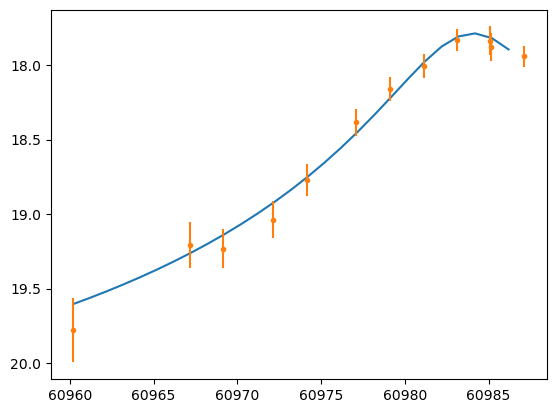

In [71]:
plot_lightcurve(dk_locus)

In [22]:
from antares_devkit.utils import filter_report
import time

Processing Locus: ANT2019ffsx4
Too skewed
Failed von Neumann threshold
0.10298705101013184


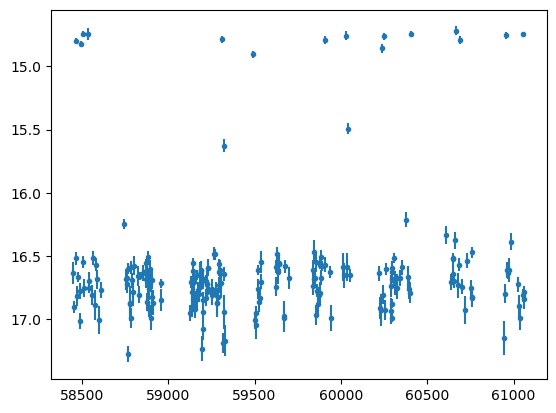

Processing Locus: ANT2020jqewc
Other known phenomenon
Other known phenomenon
0.09019589424133301


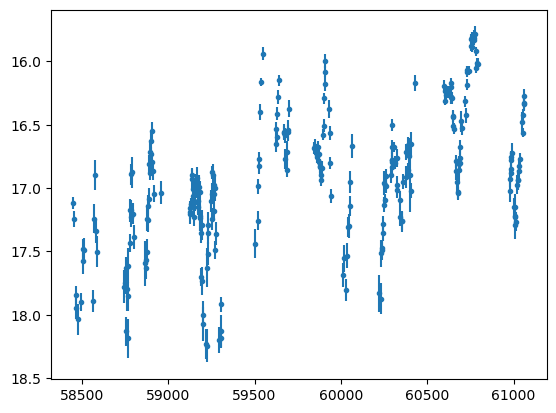

2.288818359375e-05


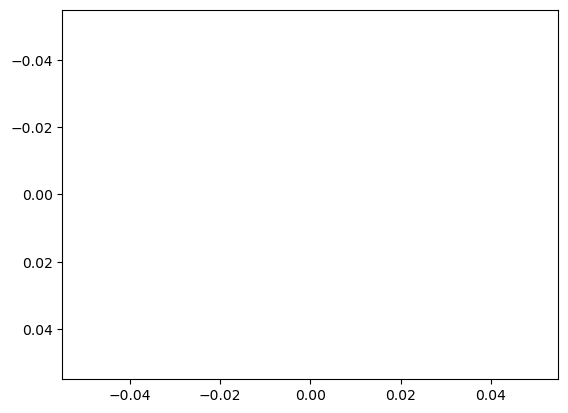

Processing Locus: ANT2025yn4m57ofaahp
Too Few Datapoints
Too Few Datapoints
0.08346176147460938


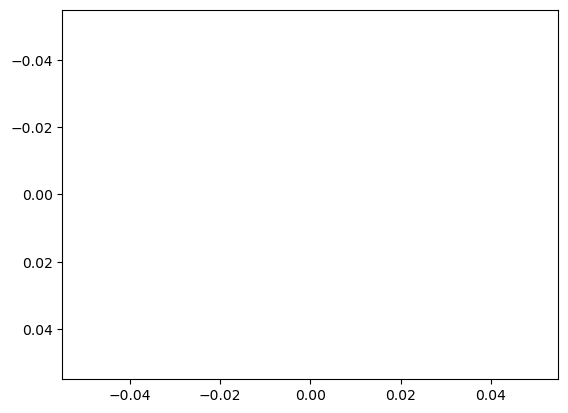

1.811981201171875e-05


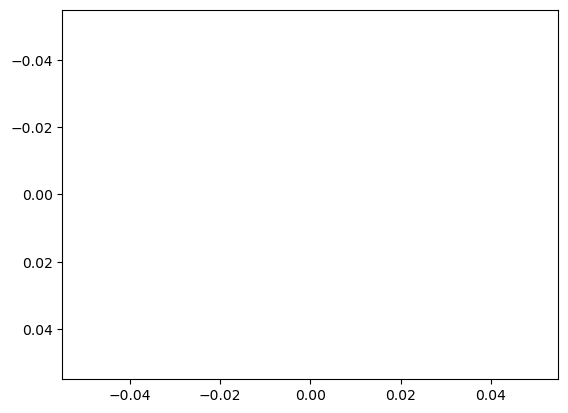

2.8133392333984375e-05


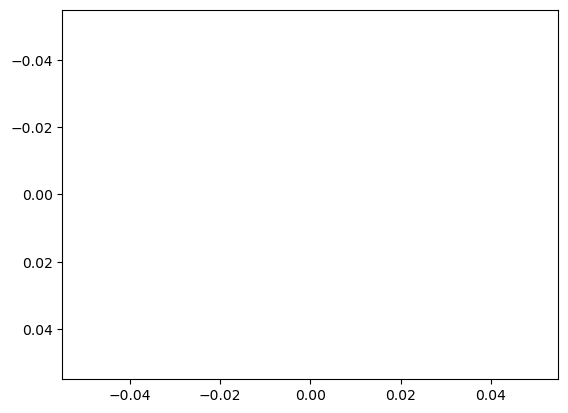

Processing Locus: ANT2020riqta
Other known phenomenon
Other known phenomenon
0.0949409008026123


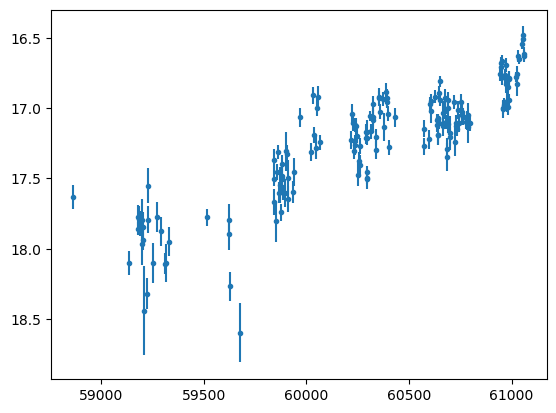

Processing Locus: ANT2020maj3g
Failed von Neumann threshold
Too skewed
0.08711791038513184


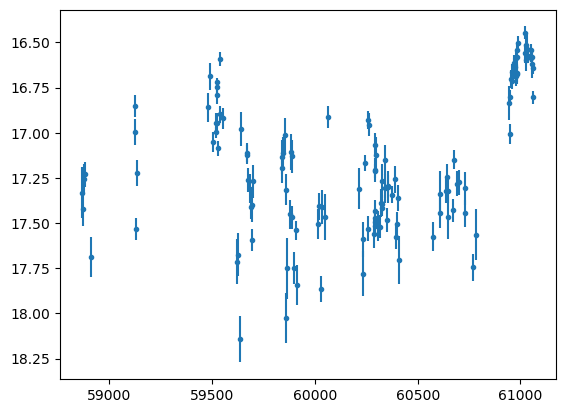

3.504753112792969e-05


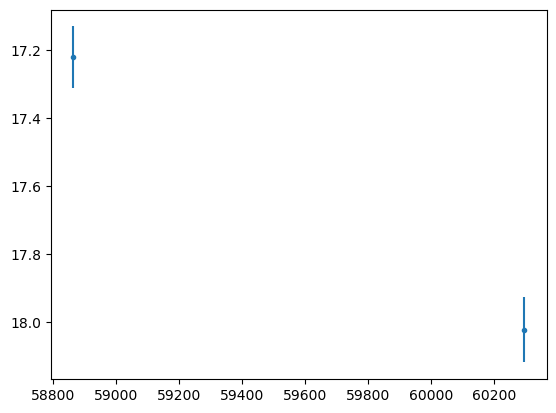

1.71661376953125e-05


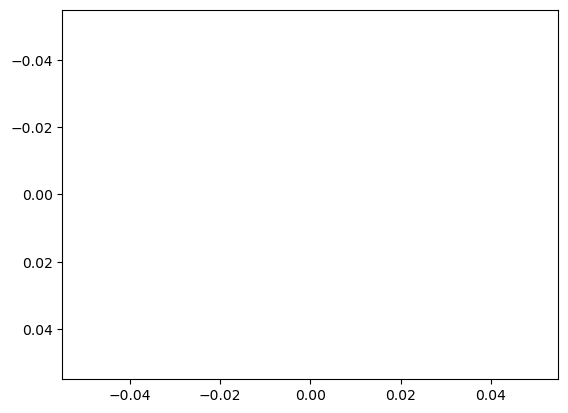

Processing Locus: ANT2020lfmdm
Other known phenomenon
Other known phenomenon
0.10610413551330566


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


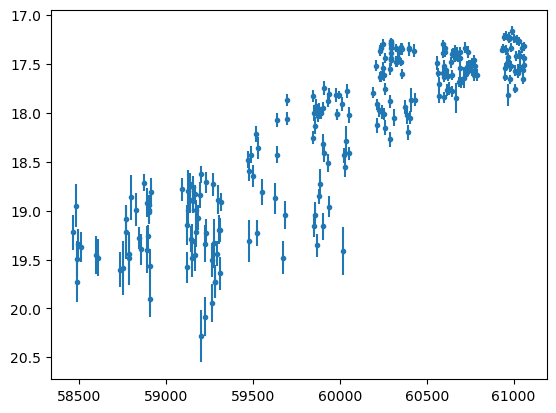

Processing Locus: ANT2020jqexe
Other known phenomenon
Other known phenomenon
0.09295892715454102


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


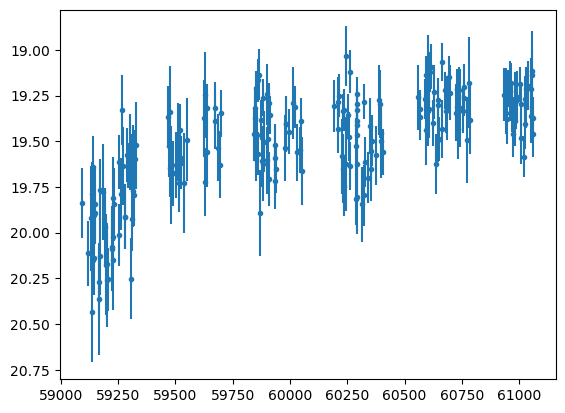

3.695487976074219e-05


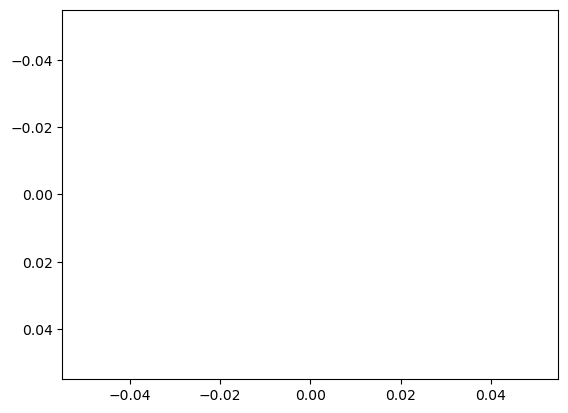

Processing Locus: ANT2020jqdnc
Failed von Neumann threshold
Failed von Neumann threshold
0.13023996353149414


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


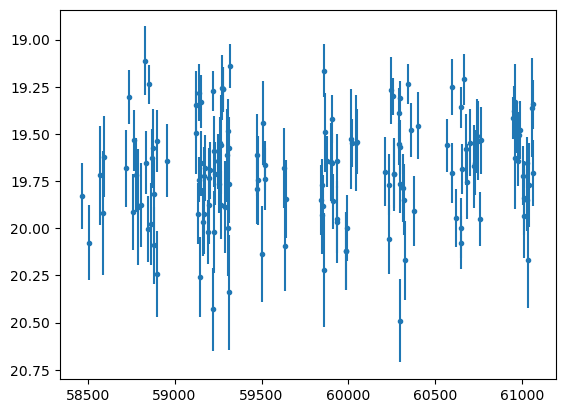

1.0013580322265625e-05


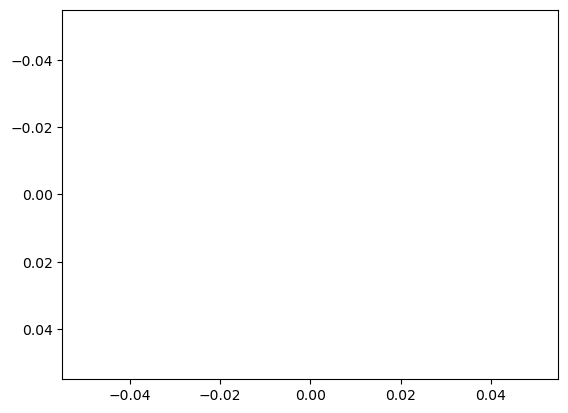

Processing Locus: ANT2020jqgmi
Other known phenomenon
Other known phenomenon
0.10124707221984863


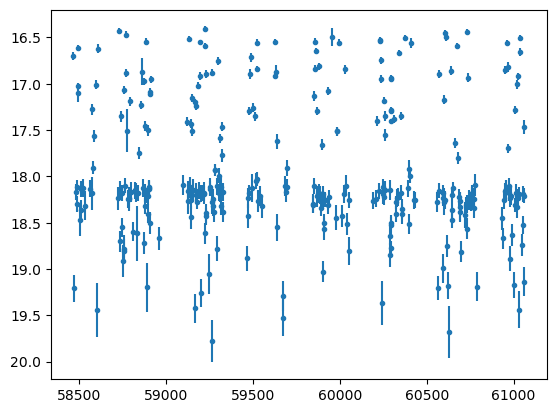

Processing Locus: ANT2020ikmee
Failed von Neumann threshold
Failed von Neumann threshold
0.10477113723754883


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


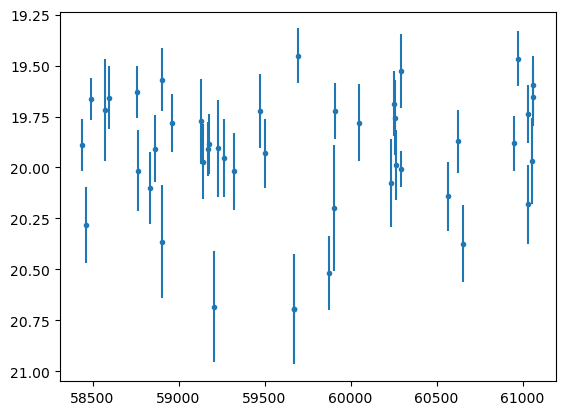

2.5987625122070312e-05


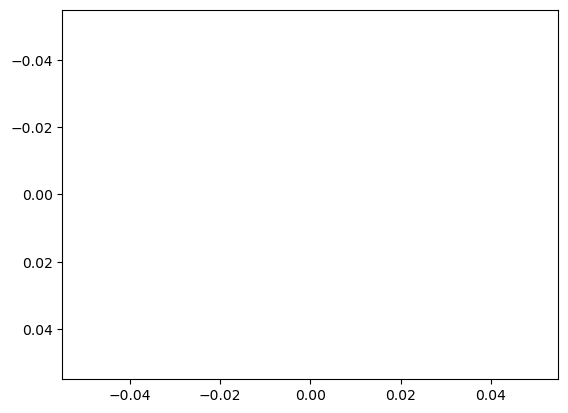

2.288818359375e-05


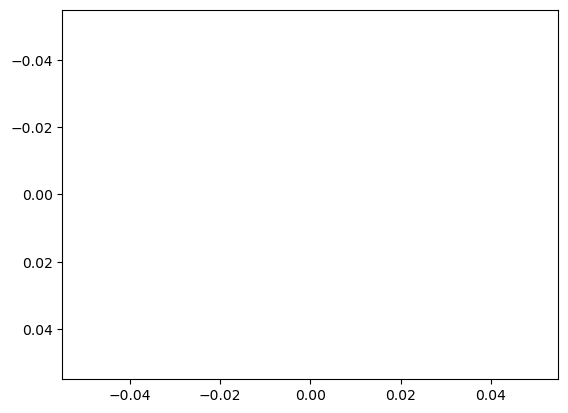

Processing Locus: ANT2020iqina
Other known phenomenon
Other known phenomenon
0.11205315589904785


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


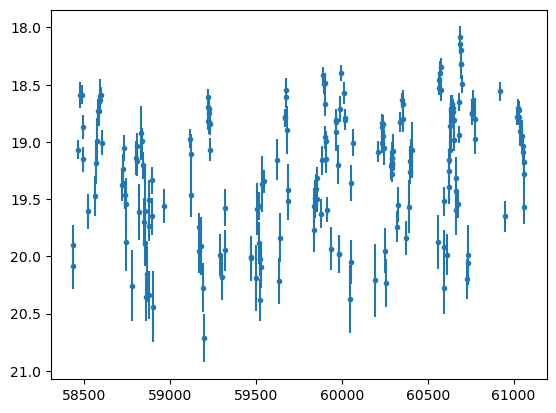

1.2159347534179688e-05


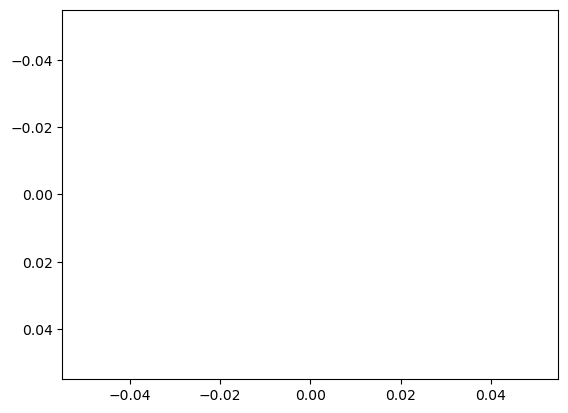

Processing Locus: ANT2020lg3pi
Other known phenomenon
Other known phenomenon
0.10543704032897949


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


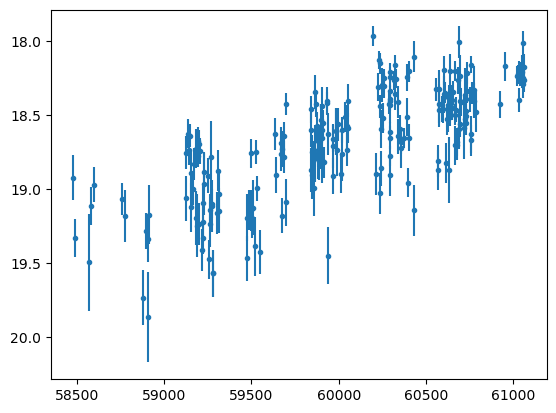

2.002716064453125e-05


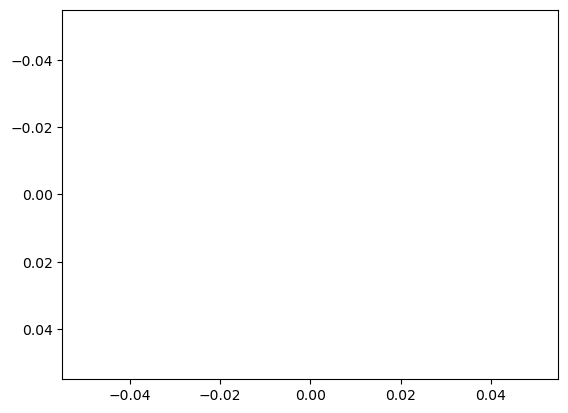

1.6927719116210938e-05


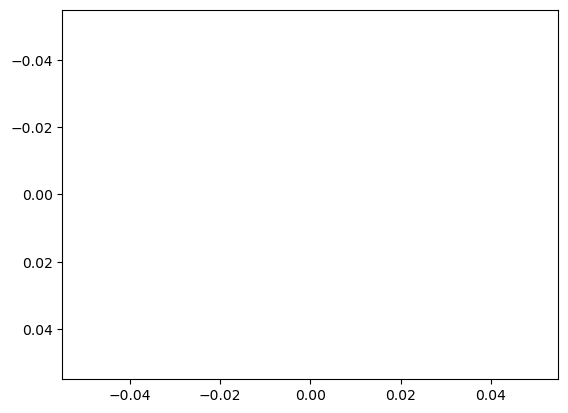

Processing Locus: ANT2020ikj3m
Other known phenomenon
Other known phenomenon
0.12064194679260254


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


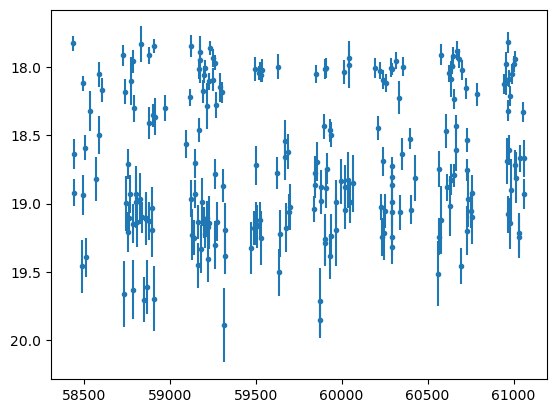

Processing Locus: ANT2019fend2
Other known phenomenon
Other known phenomenon
0.10568881034851074


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


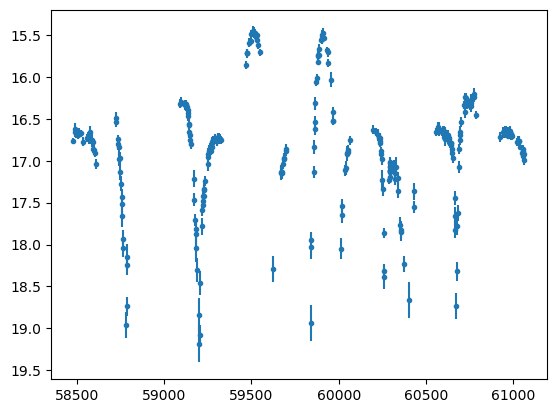

1.9311904907226562e-05


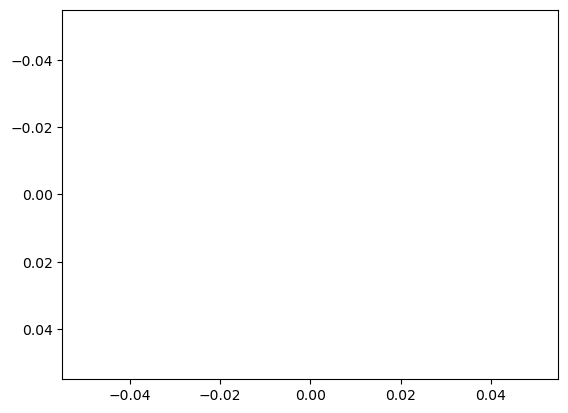

1.4066696166992188e-05


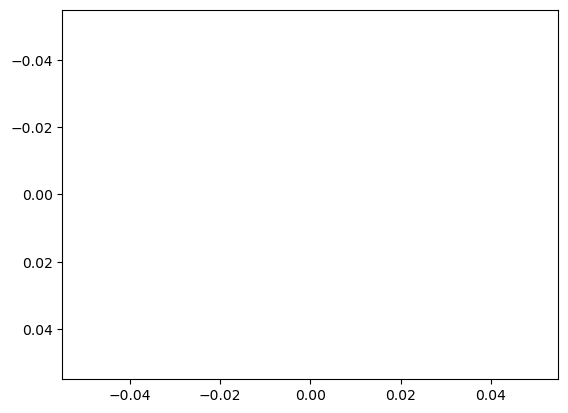

Processing Locus: ANT2020sjlum
Other known phenomenon
Other known phenomenon
0.09924602508544922


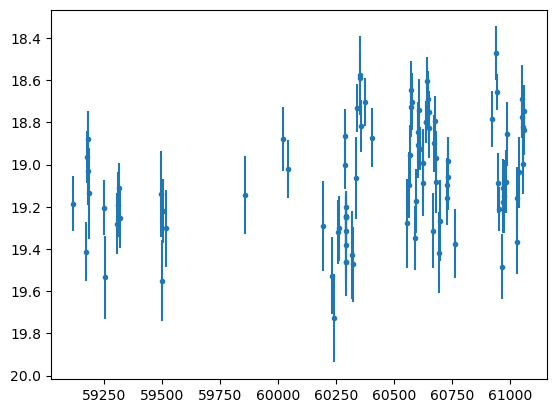

1.0967254638671875e-05


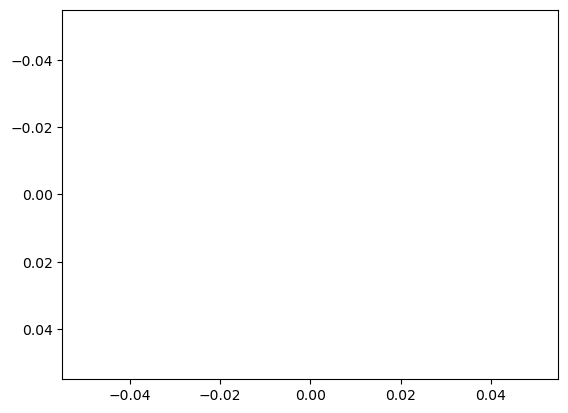

1.0013580322265625e-05


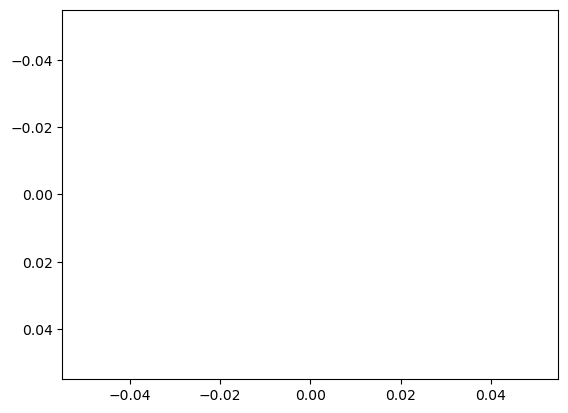

7.867813110351562e-06


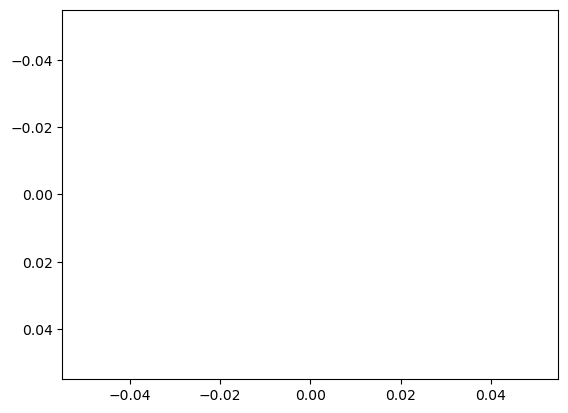

1.5974044799804688e-05


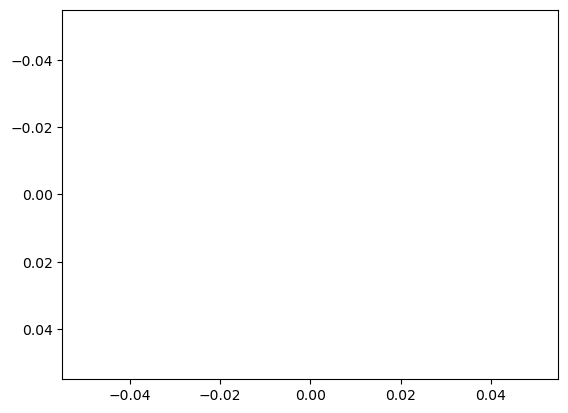

1.52587890625e-05


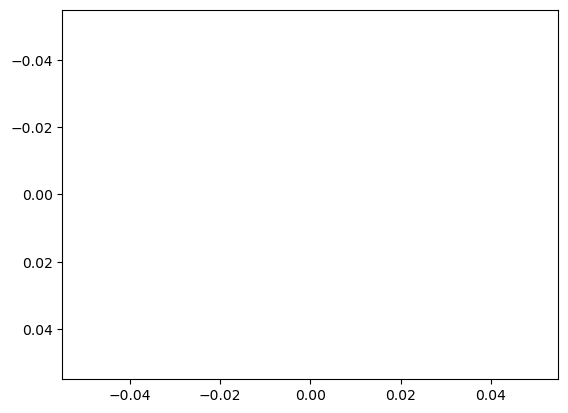

Processing Locus: ANT2020eeona
Failed von Neumann threshold
Failed von Neumann threshold
0.15700101852416992


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


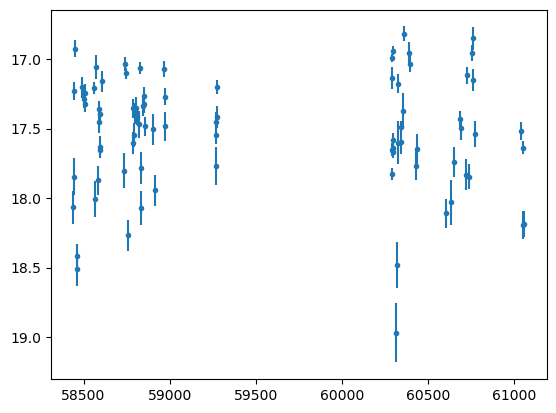

2.002716064453125e-05


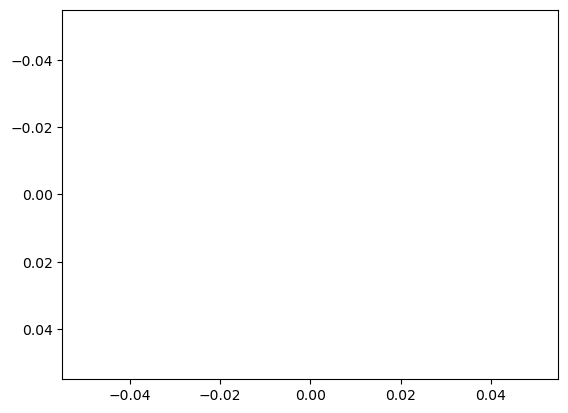

2.6941299438476562e-05


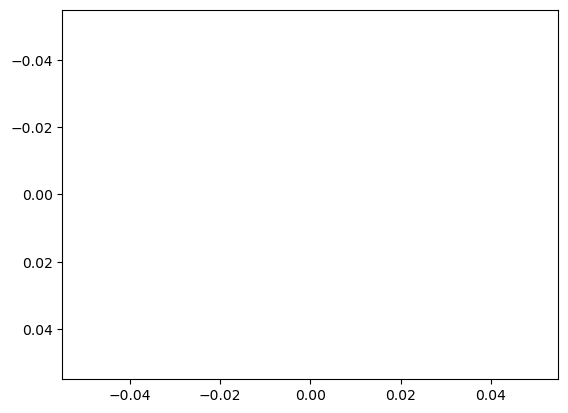

Processing Locus: ANT2020eel7k
Other known phenomenon
Other known phenomenon
0.09267473220825195


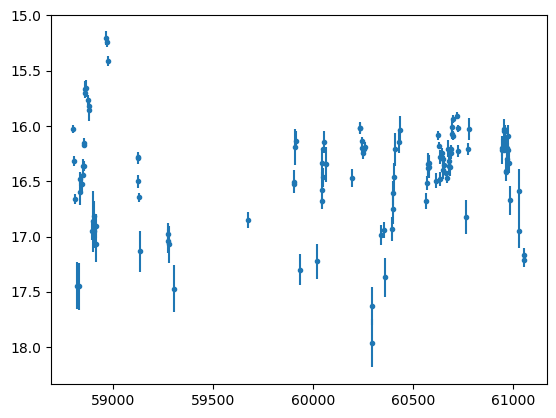

Processing Locus: ANT2020l6ksc
Other known phenomenon
Other known phenomenon
0.1161651611328125


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


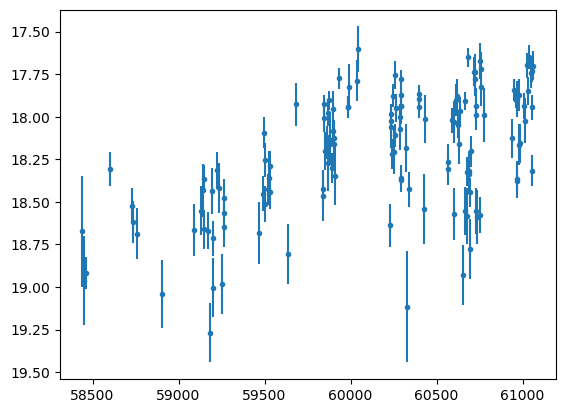

5.793571472167969e-05


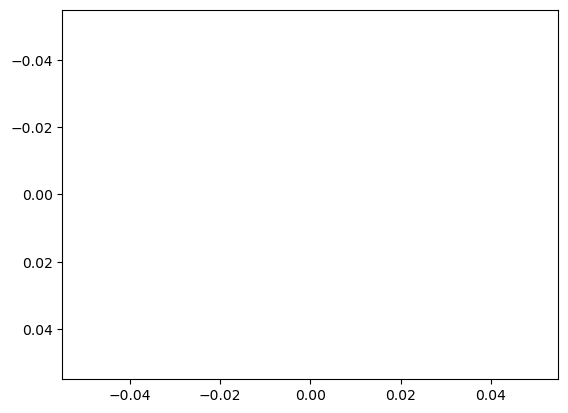

Processing Locus: ANT2020ed2fy
Other known phenomenon
Other known phenomenon
0.11515522003173828


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


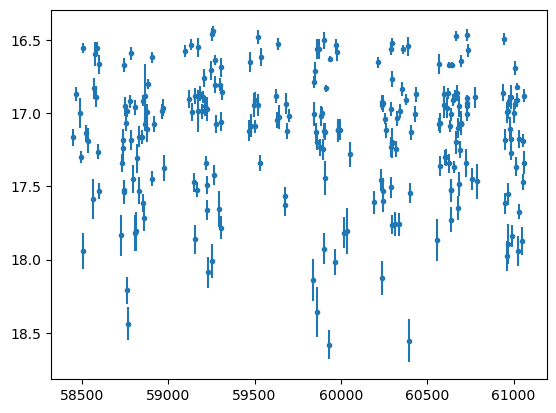

2.09808349609375e-05


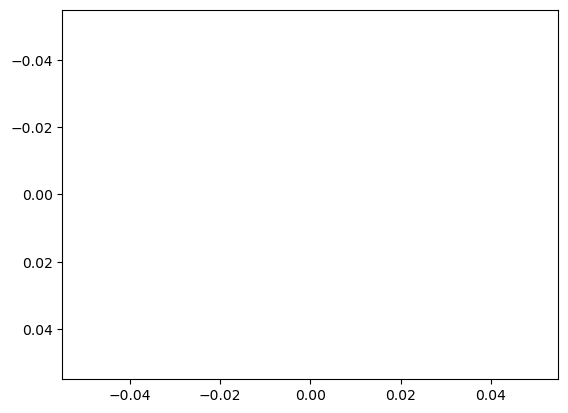

2.1219253540039062e-05


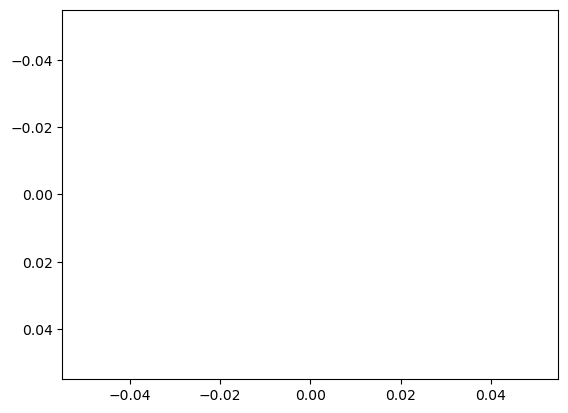

1.4066696166992188e-05


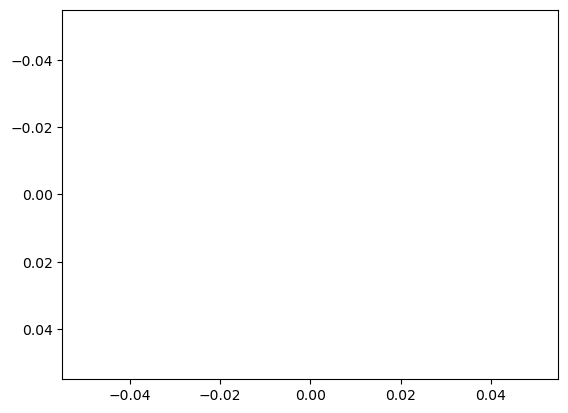

1.5735626220703125e-05


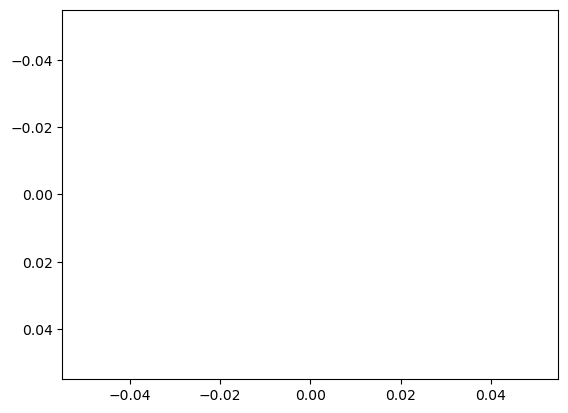

Processing Locus: ANT2020lx23i
Failed von Neumann threshold
Failed von Neumann threshold
0.20512819290161133


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


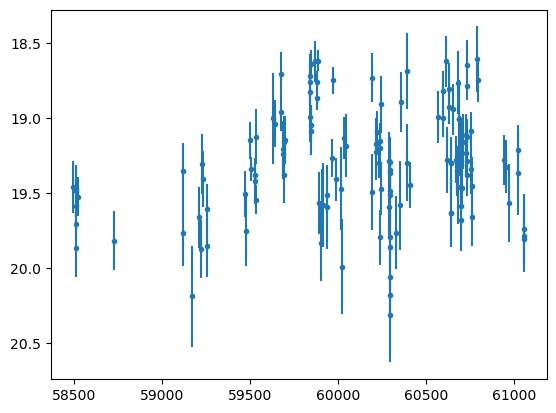

2.7894973754882812e-05


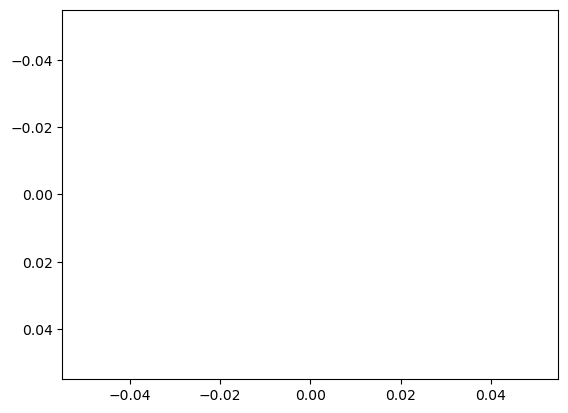

7.867813110351562e-06


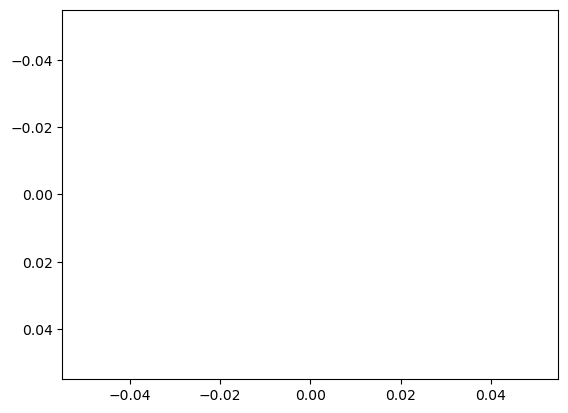

Processing Locus: ANT2020i6r2e
Failed von Neumann threshold
Failed von Neumann threshold
0.11911296844482422


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


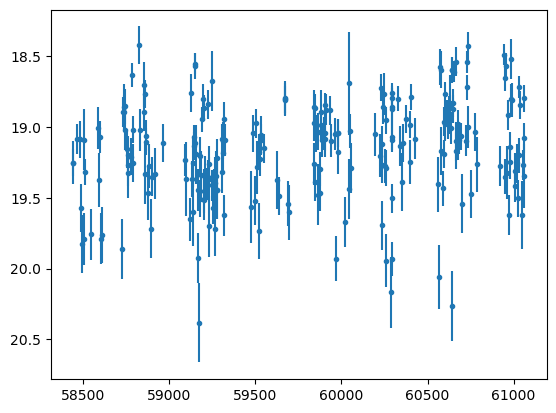

4.7206878662109375e-05


/opt/mambaforge3/envs/antares/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


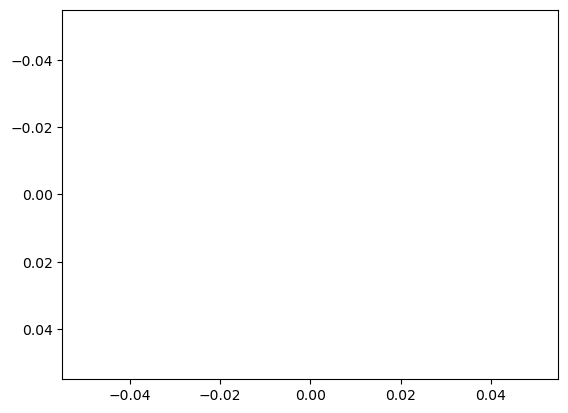

In [76]:
random_ids = search.get_random_locus_ids(n=50)
ts = np.zeros(50)
for i, random_id in enumerate(random_ids):
    locus = search.get_by_id(random_id)
    dk_locus = DevKitLocus.model_validate(locus.to_devkit())
    t0 = time.time()
    report = microlens_filter.run(locus=dk_locus)
    t_tot = time.time() - t0
    print(t_tot)
    ts[i] = t_tot
    plot_lightcurve(dk_locus)
    plt.close('all')

In [78]:
np.mean(ts)

0.04685897350311279